# SDWFS AGN Surface Density--Color Trend Plot
## Author: Benjamin Floyd

Generates a pubication plot of the AGN surface density as a function of the purity color selection threshold.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS

%matplotlib inline
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 14})

In [2]:
# Read in the SDWFS AGN catalog
sdwfs_agn = Table.read('Data_Repository/Project_Data/SPT-IRAGN/Output/SDWFS_cutout_IRAGN_purity.fits')

# List all mask files
mask_files = [cutout['MASK_NAME'][0] for cutout in sdwfs_agn.group_by('CUTOUT_ID').groups]

# Get the color thresholds used in catalog creation
with open('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/SDWFS_purity_color.json', 'r') as f:
    color_threshold_data = json.load(f)
    color_thresholds = color_threshold_data['purity_90_colors']

In [3]:
# Read in each mask file and calculate the allowable area
areas = []
for mask_file in mask_files:
    mask_img, mask_hdr = fits.getdata(mask_file, header=True)
    mask_wcs = WCS(mask_hdr)

    # Get the area of a pixel in angular units
    pixel_area = mask_wcs.proj_plane_pixel_area()

    # Find the total area of the image by adding all pixels and multiplying by the pixel area
    mask_area = np.count_nonzero(mask_img) * pixel_area
    areas.append(mask_area)

# Compute total area in sample
total_area = u.Quantity(areas).sum()

In [4]:
# For each color selection threshold, add all objects applying the appropriate corrections
completeness_correction = sdwfs_agn['COMPLETENESS_CORRECTION']
selection_membership_columns = [colname for colname in sdwfs_agn.colnames if 'SELECTION_MEMBERSHIP' in colname]

# numbers_agn = [np.sum(completeness_correction * sdwfs_agn[selection_membership_column])
#                for selection_membership_column in selection_membership_columns]
numbers_agn = []
for color in color_thresholds[:-1]:
    # cat = sdwfs_agn[sdwfs_agn['I1_MAG_APER4'] - sdwfs_agn['I2_MAG_APER4'] >= color]
    cat = sdwfs_agn
    numbers_agn.append(np.sum(cat['COMPLETENESS_CORRECTION'] * cat[f'SELECTION_MEMBERSHIP_{color:.2f}']))

In [5]:
# Create surface density array
agn_surf_den = numbers_agn / total_area

# Also generate Poisson errors for the surface densities
agn_surf_den_err = np.sqrt(numbers_agn) / total_area

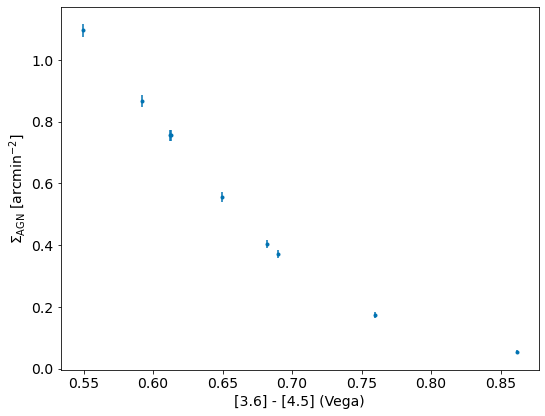

In [7]:
# Create plot
fig, ax = plt.subplots(figsize=(7.8, 6))
ax.errorbar(color_thresholds[:-1], agn_surf_den.to_value(u.arcmin**-2), yerr=agn_surf_den_err.to_value(u.arcmin**-2), fmt='.')
ax.set(xlabel='[3.6] - [4.5] (Vega)', ylabel=r'$\Sigma_{\mathrm{AGN}}$ [arcmin$^{-2}$]')
fig.tight_layout()
fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/Publication_Plots/SDWFS_AGN_surfden-color_threshold_publication.pdf')